This is an attempt to make a recommender system for women's cloths shopping. Dataset taken is over 23,000 reviews of women clothing product and 3 algorithms are used to find the most recommended item.

In [64]:
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import math
import json
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
data = pd.read_csv("review.csv")
print(data.columns)
data.rename(columns = {'Unnamed: 0':'userId'}, inplace = True)
data


Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')


,userId,Clothing ID,Age,Title,Review Text,Rating,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,2,General,Dresses,Dresses


In [120]:
print(data.shape)
df = data[['Clothing ID', 'Age', 'Rating']]
print(df)

(23486, 10)
       Clothing ID  Age  Rating
0              767   33       4
1             1080   34       5
2             1077   60       3
3             1049   50       5
4              847   47       5
...            ...  ...     ...
23481         1104   34       5
23482          862   48       3
23483         1104   31       3
23484         1084   28       3
23485         1104   52       5

[23486 rows x 3 columns]


In [67]:
print("\nTotal no of ratings :",df.shape[0])
print("Total No of products  :", len(np.unique(df['Clothing ID'])))
product_rate_mean=pd.DataFrame(df.groupby('Clothing ID')['Rating'].agg(['mean','count']),
                            columns=['mean','count']).sort_values(by=['count','mean'],ascending=False)[:20]
plot_df = product_rate_mean.head(5)
product_rate_mean.head(20)


Total no of ratings : 23486
Total No of products  : 1206


,mean,count
Clothing ID,,
1078,4.204102,1024
862,4.200993,806
1094,4.189153,756
1081,4.281787,582
872,4.383486,545
829,4.193548,527
1110,4.281250,480
868,3.946512,430
895,4.299505,404


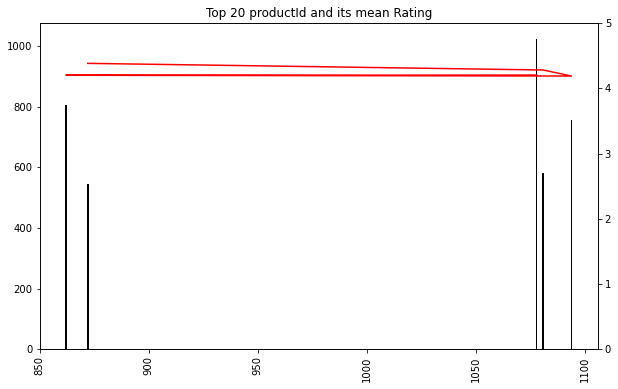

In [68]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.bar(plot_df.index,plot_df['count'],color='black')
plt.xticks(rotation=90)
ax2 = ax1.twinx()
ax2.plot(plot_df.index,plot_df['mean'],color='red')
plt.ylim(0, 5)
plt.title("Top 20 productId and its mean Rating")
plt.show()


5    13131
4     5077
3     2871
2     1565
1      842
Name: Rating, dtype: int64


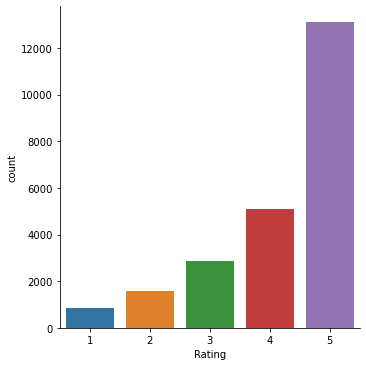

In [69]:
print(df.Rating.value_counts())
sns.catplot("Rating",data=df,kind='count')

# Algorithm 1 - Popularity based

Here all reviews taken per product which has more than 30 reviews in the dataset. Review ratings and count of reviews per product is taken into account to find the most popular item and recommend it to the user

# Method - 1

In [70]:
new_df=df.groupby("Clothing ID").filter(lambda x:x['Rating'].count() >=30)

(23163, 3)

5    12934
4     5014
3     2843
2     1541
1      831
Name: Rating, dtype: int64


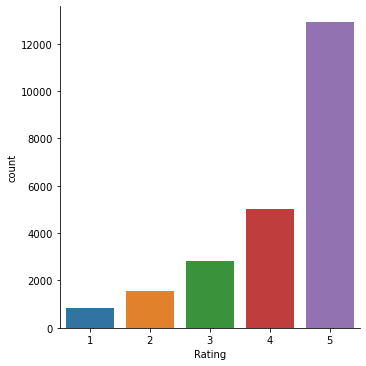

In [72]:
print(data_final.Rating.value_counts())
sns.catplot("Rating",data=data_final,kind='count')

In [73]:
processed_data=data_final[data_final['Clothing ID'].isin(data_final['Clothing ID'].value_counts()[data_final['Clothing ID'].value_counts()>=1].index)]


In [74]:
final_ratings_matrix = pd.pivot_table(processed_data,index='Age',columns='Clothing ID',values = 'Rating').fillna(0)

In [75]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(processed_data, test_size = 0.3, random_state=10)
print(train_data.shape)
print(test_data.shape)

(16214, 3)
(6949, 3)


In [76]:
train_data_grouped = train_data.groupby('Clothing ID').agg({'Age':'count','Rating':'mean'}).reset_index()
train_data_grouped.rename(columns={'Age':'count','Rating':'mean'},inplace=True)
train_data_grouped.head()

,Clothing ID,count,mean
0,1,3,4.0
1,2,1,4.0
2,3,1,5.0
3,4,1,5.0
4,5,1,5.0


In [77]:
train_data_sort = train_data_grouped.sort_values(['count'], ascending = 0) 
train_data_sort['Rank'] = train_data_sort['count'].rank(ascending=0, method='first') 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,Clothing ID,count,mean,Rank
914,1078,671,4.137109,1.0
708,862,535,4.257944,2.0
930,1094,523,4.191205,3.0
917,1081,404,4.262376,4.0
718,872,378,4.351852,5.0


These are the 5 most top reviewd products, and they are mentioned from 1st to 5th based on their mean rating by all reviewers

# Algorithm 2 - Model Based CF - Using SVD

In [78]:
ratings_matrix = new_df.pivot_table(values='Rating', index='Age', columns='Clothing ID', fill_value=0)
ratings_matrix.head()

Clothing ID,169,282,520,815,818,819,820,822,823,824,...,1099,1100,1103,1104,1110,1111,1116,1121,1123,1126
Age,,,,,,,,,,,,,,,,,,,,,
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.00,0.0,0.0,0.0,0.0,0.0
20,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,4.00,0.0,2.5,5.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,...,0.0,0.0,0.0,5.0,5.00,0.0,0.0,0.0,4.0,0.0
22,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,...,5.0,0.0,0.0,0.0,4.25,0.0,0.0,0.0,5.0,0.0


In [79]:
Transpose = ratings_matrix.T

In [80]:
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
new_matrix = SVD.fit_transform(Transpose)
correlation_matrix = np.corrcoef(new_matrix)
correlation_matrix.shape
Transpose.index[54]

907

In [81]:
new_matrix.shape
new_matrix


array([[13.91122127,  0.37796607, 11.0991782 , ...,  1.79922328,
        -1.8541448 ,  2.00281208],
       [14.83701527, -7.45932672, -1.87806313, ...,  0.53164068,
         1.23709634,  2.10723643],
       [12.42351148, -6.33254803,  3.86107237, ...,  1.14942899,
        -1.72452844, -3.53108048],
       ...,
       [13.34334707, -0.0286285 , -0.54554829, ..., -4.11696726,
        -3.56177618,  2.19753272],
       [14.49882504, -4.97103823,  4.70558322, ...,  2.83729861,
        -1.73708767, -1.84803733],
       [16.70960194,  0.60711034,  8.9702769 , ..., -2.60293072,
         3.01264646,  1.27710689]])

In [82]:
print(correlation_matrix[0])

[1.         0.50849734 0.66325671 0.69743741 0.7458835  0.65356066
 0.64960945 0.52284718 0.66377202 0.71605734 0.70470721 0.79028263
 0.66169333 0.68342773 0.59838964 0.62787031 0.76337844 0.66543077
 0.69902427 0.7241701  0.35455037 0.49349509 0.61742461 0.79326805
 0.68314045 0.68039034 0.43120192 0.65264359 0.67128661 0.66901892
 0.698982   0.68208698 0.59842096 0.58159897 0.66825525 0.6448496
 0.55405003 0.5950267  0.63532032 0.6963214  0.6748806  0.77274465
 0.70763184 0.68941055 0.65920311 0.76343222 0.49022819 0.64669982
 0.5076315  0.81107066 0.66317708 0.45562473 0.52498867 0.61059583
 0.66137569 0.6626858  0.31537562 0.73795954 0.68547299 0.43107919
 0.68166399 0.62299883 0.49559908 0.57752177 0.55445645 0.54379109
 0.76013926 0.61349435 0.63029778 0.8723984  0.55470976 0.79960506
 0.71726755 0.66647563 0.56554443 0.72647953 0.67378328 0.65704491
 0.70370028 0.64952235 0.66979834 0.68783989 0.73316536 0.65280587
 0.73093813 0.68573717 0.72752712 0.73976121 0.53505644 0.70164

In [83]:
product_names = list(Transpose.index)
product_ID = product_names.index(974)
correlation_product_ID = correlation_matrix[product_ID]
Recommend = list(Transpose.index[correlation_product_ID > 0.9])
Recommend[:10]

[825, 875, 878, 974, 995, 1025, 1054, 1082, 1091, 1111]

# Algorithm 3 -  CF Using K means


In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [85]:
data = data.dropna()


In [86]:
df = data[['Clothing ID', 'Review Text', 'Rating']]
df

,Clothing ID,Review Text,Rating
2,1077,I had such high hopes for this dress and reall...,3
3,1049,"I love, love, love this jumpsuit. it's fun, fl...",5
4,847,This shirt is very flattering to all due to th...,5
5,1080,"I love tracy reese dresses, but this one is no...",2
6,858,I aded this in my basket at hte last mintue to...,5
...,...,...,...
23481,1104,I was very happy to snag this dress at such a ...,5
23482,862,"It reminds me of maternity clothes. soft, stre...",3
23483,1104,"This fit well, but the top was very see throug...",3
23484,1084,I bought this dress for a wedding i have this ...,3


In [87]:
vectorizer = TfidfVectorizer(stop_words='english')
transformed = vectorizer.fit_transform(df["Review Text"])
transformed

<19662x13286 sparse matrix of type '<class 'numpy.float64'>'
	with 476893 stored elements in Compressed Sparse Row format>

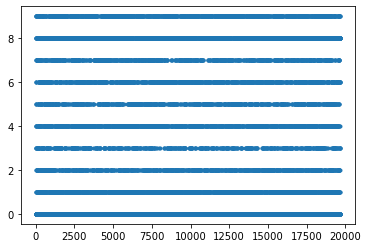

In [88]:
temp = transformed
kmeans = KMeans(n_clusters = 10, init = 'k-means++')
y_kmeans = kmeans.fit_predict(temp)
plt.plot(y_kmeans, ".")
plt.show()

In [60]:
true_k = 10

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 sweater
 love
 soft
 color
 wear
 great
 like
 just
 sleeves
 size
Cluster 1:
 shirt
 love
 great
 wear
 like
 cute
 soft
 material
 little
 size
Cluster 2:
 petite
 regular
 xs
 size
 length
 ordered
 dress
 fit
 tried
 like
Cluster 3:
 love
 like
 fabric
 fit
 size
 just
 color
 wear
 flattering
 look
Cluster 4:
 really
 like
 just
 love
 fabric
 fit
 size
 nice
 look
 pretty
Cluster 5:
 great
 love
 fit
 looks
 color
 comfortable
 fits
 jeans
 wear
 dress
Cluster 6:
 pants
 jeans
 pair
 fit
 love
 size
 wear
 perfect
 comfortable
 great
Cluster 7:
 cute
 super
 love
 little
 comfortable
 size
 wear
 great
 like
 dress
Cluster 8:
 small
 size
 medium
 large
 wear
 ordered
 runs
 usually
 fit
 love
Cluster 9:
 dress
 love
 size
 fit
 wear
 like
 beautiful
 just
 fabric
 flattering


In [107]:
Y = vectorizer.transform(["sweater"])
prediction = model.predict(Y)
print(prediction)
prediction[0]

[0]


0

In [109]:
cluster_map = pd.DataFrame()

cluster_map['Clothing ID'] = data.index.values
cluster_map['cluster'] = model.labels_
cluster_map[cluster_map.cluster == prediction[0]].head()

,Clothing ID,cluster
26,29,0
37,48,0
142,182,0
144,184,0
151,191,0
